## 自定义层次

In [2]:
import tensorflow.keras as keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import os
import sys
import time
import tensorflow as tf


In [3]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.4.2
numpy 1.18.5
pandas 1.3.3
sklearn 1.0
tensorflow 2.3.0
tensorflow.keras 2.4.0


### 1. 导入数据

In [4]:
from sklearn.datasets import  fetch_california_housing

# 加利福尼亚房屋数据集
housing  = fetch_california_housing()

# 打印数据集描述
print(housing.DESCR)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [5]:
# 打印特征shape
print(housing.data.shape)
# 打印结果shape
print(housing.target.shape)

(20640, 8)
(20640,)


In [6]:
import pprint

# 打印数据, pprint 和 print 类似, 但是 pprint 打出的数据结构更加完整
pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


#### 1.1 分隔数据集

In [7]:
from sklearn.model_selection import train_test_split

# 划分训练集和测试集
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)

# 对训练集再次划分为训练集和验证集
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=20)

In [8]:
# 打印shape
print(x_train_all.shape, y_train_all.shape)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(15480, 8) (15480,)
(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


#### 1.2 数据归一化

In [9]:
# 打印数据的最大最小值
print(np.max(x_train), np.min(x_train))

35682.0 -124.35


In [10]:
# 可以看到数据集的 scale 过大, 所以我们需要做数据集的归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 数据归一化
# 注意 fit_transform 和 transform 的区别
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)
x_test_scaled = scaler.fit_transform(x_test)

In [11]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

94.77756736476127 -2.3750505046419277


### 2. 搭建神经网络

#### 2.1 构建神经网络

In [12]:
model = keras.Sequential([
    keras.layers.Dense(units=30, activation='relu', input_shape=x_train.shape[1:]), # x_train.shape[1:] (8,)
    keras.layers.Dense(units=1)
])

In [13]:
# 展示模型架构
# [None, 8] * W + b => W = [8, 30] , b = [30] => [None, 8] * [8, 30] + 30 = 270
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


#### 2.2 自定义loss

In [14]:
def customized_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [15]:
# 编译模型
# 损失函数: 均值方差, 优化方法: 随机梯度下降
model.compile(loss=customized_mse, optimizer="sgd", metrics=['accuracy', 'mean_squared_error'])

In [16]:
# 设置回调函数
# patience : 连续 5 次没有提升就中断
# min_delta : 连续提升小于1e-2提前中断
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=5, min_delta=1e-4
    )
]

#### 2.3 训练模型

In [17]:
# 训练模型
history = model.fit(x_train_scaled, y_train, epochs = 30,
                    validation_data=(x_valid_scaled, y_valid), callbacks=callbacks)

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 0.8357 - accuracy: 0.0034 - mean_squared_error: 0.8357 - val_loss: 0.5612 - val_accuracy: 0.0013 - val_mean_squared_error: 0.5612
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6844 - accuracy: 0.0034 - mean_squared_error: 0.6844 - val_loss: 0.4916 - val_accuracy: 0.0013 - val_mean_squared

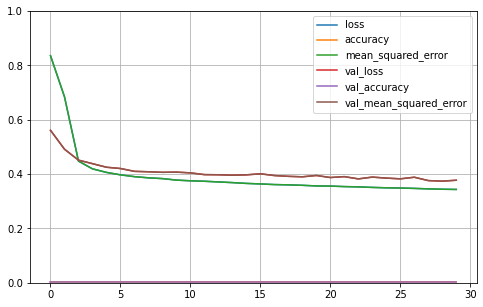

In [18]:
# 绘制图像
def plot_learning_rate(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    # 开启网格
    plt.grid(True)
    # 设置y轴范围
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_rate(history)

In [19]:
# 使用测试集验证
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.4057 - accuracy: 0.0033 - mean_squared_error: 0.4057


[0.4056518077850342, 0.0032945736311376095, 0.4056518077850342]

### 3. 自定义DenseLayer

#### 3.1 Layer

In [22]:
layer = keras.layers.Dense(units=100)
# input_shape 指定输入数据的形状, None 表示值可以是变长的
layer = keras.layers.Dense(units=100, input_shape=(None, 5))

# layer 可以作为函数直接使用
layer(np.zeros([2, 5]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(2, 100), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [25]:
# Dens layer : x * w + b => w = kernel,  b = bias
print(layer.variables)
print(layer.trainable_variables)

[<tf.Variable 'dense_7/kernel:0' shape=(5, 100) dtype=float32, numpy=
array([[ 0.05181314, -0.21912687, -0.16724841,  0.23587377, -0.03406428,
         0.143129  , -0.05671304, -0.12718293,  0.04417996, -0.05261713,
         0.09781186, -0.10163175,  0.1290498 , -0.01475798,  0.00632359,
         0.0215454 ,  0.00466646, -0.22102565,  0.0883023 ,  0.01593579,
         0.20056455,  0.2346689 ,  0.07609083, -0.19783807, -0.20500588,
         0.12588184,  0.16947974, -0.21091065,  0.11156254, -0.06506047,
         0.11021073, -0.01692502, -0.07450248,  0.0680079 , -0.17072731,
        -0.13564092, -0.12043179,  0.16459768, -0.00919764, -0.03657489,
         0.12759979, -0.0083721 , -0.19896983,  0.08241157,  0.14473398,
        -0.23297882,  0.16460638,  0.1313252 ,  0.07291438,  0.151731  ,
        -0.20684022, -0.03348352,  0.15415923, -0.14087248,  0.02834053,
         0.18052702, -0.00460537,  0.16132234, -0.19842036,  0.13230558,
        -0.09013593,  0.03063883,  0.03960069, -0.2216

#### 3.2 自定义Layer

In [26]:
# customizer dense layer

class CustomizerDenserLayer(keras.layers.Layer):

    def __init__(self, units, activation=None, **kwargs):
        # 定义输出
        self.units = units
        # 定义激活函数
        self.activation = keras.layers.Activation(activation)
        super(CustomizerDenserLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        """
            构建所需要的参数
        :param input_shape:
        :return:
        """
        # kernel => w
        # x * w + b => input_shape : [None, a] w: [a, b] => output_shape : [None, b]
        self.kernel = self.add_weight(
            # 设置 initializer 参数初始化方式 : 均匀分布
            # trainable 设置当前变量是否可以训练
            name='kernel', shape=(input_shape[1], self.units), initializer="uniform", trainable=True
        )
        # 初始化偏置值
        self.bias = self.add_weight(
            name='bias', shape=(self.units, ), initializer="zero", trainable=True
        )
        super(CustomizerDenserLayer, self).build(input_shape)

    def call(self, x):

        """
            完成计算, 输入 => 输出 
        :param x:
        :return:
        """
        return self.activation(x @ self.kernel + self.bias)

In [27]:
model = keras.Sequential([
    CustomizerDenserLayer(units=30, activation='relu', input_shape=x_train.shape[1:]), # x_train.shape[1:] (8,)
    CustomizerDenserLayer(units=1)
])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customizer_denser_layer (Cus (None, 30)                270       
_________________________________________________________________
customizer_denser_layer_1 (C (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss=customized_mse, optimizer="sgd", metrics="accuracy")
history = model.fit(x_train_scaled, y_train, epochs = 10,
                    validation_data=(x_valid_scaled, y_valid))

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 5.5143 - accuracy: 1.7227e-04 - val_loss: 5.3729 - val_accuracy: 0.0000e+00
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 5.3616 - accuracy: 3.4453e-04 - val_loss: 5.1929 - val_accuracy: 0.0000e+00

In [39]:
history.history

{'loss': [5.514345169067383,
  5.361602783203125,
  5.06840705871582,
  4.373770713806152,
  3.3301353454589844,
  2.4927310943603516,
  1.9346110820770264,
  1.5810678005218506,
  1.3415497541427612,
  1.198025107383728],
 'accuracy': [0.00017226528143510222,
  0.00034453056287020445,
  0.00034453056287020445,
  0.00034453056287020445,
  0.00034453056287020445,
  0.0006029285141266882,
  0.0009474590769968927,
  0.001291989698074758,
  0.0013781222514808178,
  0.0014642549213021994],
 'val_loss': [5.372868061065674,
  5.192887783050537,
  4.82185173034668,
  3.852037191390991,
  2.9914913177490234,
  2.353792190551758,
  1.9079710245132446,
  1.5885869264602661,
  1.4047144651412964,
  1.198387861251831],
 'val_accuracy': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.00025839792215265334,
  0.0005167958443053067,
  0.0005167958443053067,
  0.0005167958443053067]}

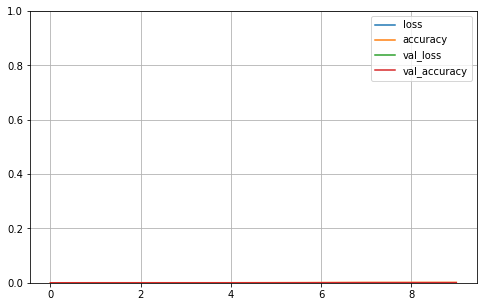

In [40]:
# 绘制图像
def plot_learning_rate(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    # 开启网格
    plt.grid(True)
    # 设置y轴范围
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_rate(history)

### 4. 使用lambda自定义层次

In [41]:
# softplus => log(1+e^x)
customized_softplus = keras.layers.Lambda(lambda  x : tf.nn.softplus(x))
print(customized_softplus([-5., -10., 0., 1.]))

tf.Tensor([6.7153485e-03 4.5398898e-05 6.9314718e-01 1.3132616e+00], shape=(4,), dtype=float32)


In [42]:
model = keras.Sequential([
    CustomizerDenserLayer(units=30, activation='relu', input_shape=x_train.shape[1:]), # x_train.shape[1:] (8,)
    CustomizerDenserLayer(units=1),
    # 等价于 keras.layers.Dense(1, activation='softplus')
    customized_softplus
])

model.compile(loss="mean_squared_error", optimizer='sgd', metrics=['accuracy'])
history = model.fit(x_train_scaled, y_train, epochs=10, validation_data=(x_valid_scaled, y_valid))

Epoch 1/10
363/363 [==============================] - 0s 1ms/step - loss: 1.2298 - accuracy: 0.0034 - val_loss: 0.6520 - val_accuracy: 0.0013
Epoch 2/10
363/363 [==============================] - 0s 826us/step - loss: 0.6048 - accuracy: 0.0034 - val_loss: 0.5596 - val_accuracy: 0.0013

In [37]:
history.history

{'loss': [5.626768589019775,
  5.600527763366699,
  5.600524425506592,
  5.600523948669434,
  5.600524425506592,
  5.600520610809326,
  5.600526332855225,
  5.600523948669434,
  5.600526332855225,
  5.600525379180908],
 'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'val_loss': [5.510568141937256,
  5.510568141937256,
  5.510568141937256,
  5.510568141937256,
  5.510568141937256,
  5.510568141937256,
  5.510568141937256,
  5.510568141937256,
  5.510568141937256,
  5.510568141937256],
 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}